# Rice Yield Prediction: PyTorch Neural Network with Optuna Tuning

## Overview
This notebook trains a **Feed-Forward Neural Network (MLP)** using **PyTorch** to predict Rice yields. 

## Methodology
1.  **Data Setup:** Loading parquet data and splitting by year.
2.  **Preprocessing:** Imputing missing values and Standard Scaling (crucial for NNs).
3.  **PyTorch Setup:** Converting data to Tensors and creating DataLoaders.
4.  **Baseline:** Naive approach (Last Year's Yield).
5.  **Initial Model:** Defining a class-based `nn.Module` and training with a custom training loop (Loss curves included).
6.  **Optimization:** Using **Optuna** to find the best architecture (Layers, Hidden Units, Dropout, LR).
7.  **Final Evaluation:** Retraining on full data and comparing RMSE/R2.

In [11]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


### 1. Data Loading & Feature Selection

In [12]:
# Load dataset
df = pd.read_parquet('Parquet/XY_version1.parquet')

# Define Target
TARGET_COL = 'Y_rice'
LAG_1_FEATURE = 'avg_yield_rice_1y'

# Clean Missing Targets
df_model = df.dropna(subset=[TARGET_COL])

# Select Features
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

print(f"Data Loaded. Features: {len(feature_cols)}")

Data Loaded. Features: 67


### 2. Preprocessing & Tensor Conversion
We split by year, scale the data using Scikit-Learn, and then convert to PyTorch Tensors.

In [13]:
# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# 1. Create Masks
mask_train = df_model['year'] < TRAIN_END_YEAR
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
mask_test = df_model['year'] >= VAL_END_YEAR

# 2. Split Dataframes
X_train_raw = df_model[mask_train][feature_cols]
y_train_raw = df_model[mask_train][TARGET_COL].values.reshape(-1, 1)

X_val_raw = df_model[mask_val][feature_cols]
y_val_raw = df_model[mask_val][TARGET_COL].values.reshape(-1, 1)

X_test_raw = df_model[mask_test][feature_cols]
y_test_raw = df_model[mask_test][TARGET_COL].values.reshape(-1, 1)

# --- SKLEARN PREPROCESSING ---
print("Imputing and Scaling...")
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Pipe: Train -> Val -> Test
X_train_np = scaler.fit_transform(imputer.fit_transform(X_train_raw))
X_val_np = scaler.transform(imputer.transform(X_val_raw))
X_test_np = scaler.transform(imputer.transform(X_test_raw))

# --- PYTORCH TENSORS ---
def to_tensor(X, y, device):
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_np, y_train_raw, device)
X_val_t, y_val_t = to_tensor(X_val_np, y_val_raw, device)
X_test_t, y_test_t = to_tensor(X_test_np, y_test_raw, device)

print(f"Training Tensor Shape: {X_train_t.shape}")

Imputing and Scaling...
Training Tensor Shape: torch.Size([3676, 67])


### 3. Baseline Model
Calculating performance if we simply predicted "Last Year's Yield".

In [14]:
# Baseline: yield(t) = yield(t-1)
y_pred_baseline = df_model[mask_test][LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~np.isnan(y_test_raw.flatten())
y_test_clean = y_test_raw.flatten()[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 527.17


### 4. PyTorch Model Definition & Training Loop
We define a flexible `RiceYieldModel` class and a reusable training function with Early Stopping.

Training Initial PyTorch Model...


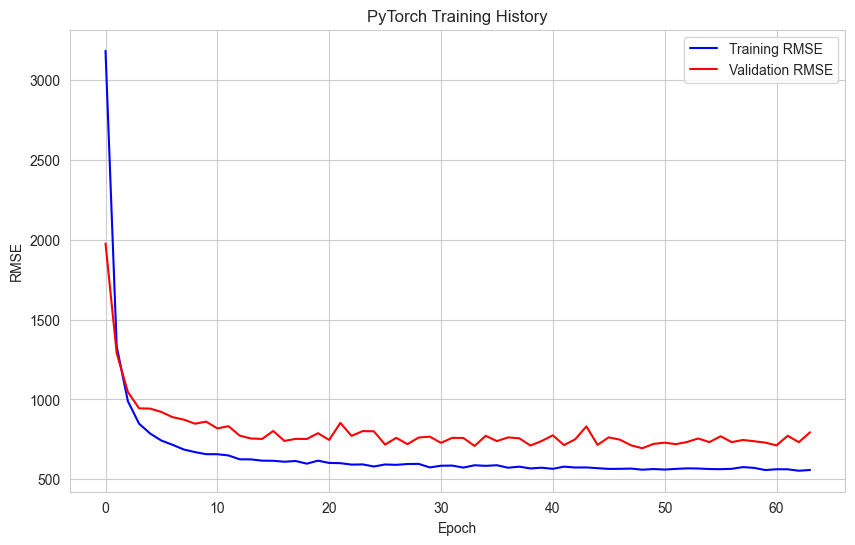

Initial Model Test RMSE: 1265.43


In [15]:
# --- MODEL ARCHITECTURE ---
class RiceYieldModel(nn.Module):
    def __init__(self, input_dim, n_layers=2, units=64, dropout=0.1):
        super(RiceYieldModel, self).__init__()
        layers = []
        
        in_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, units))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = units
            
        layers.append(nn.Linear(in_dim, 1)) # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- TRAINING HELPER FUNCTION ---
def train_model(model, train_loader, X_val, y_val, epochs=150, lr=0.001, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        batch_losses = []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            
        avg_train_loss = np.mean(batch_losses)
        
        # Store history (RMSE for readability)
        history['train_loss'].append(np.sqrt(avg_train_loss))
        history['val_loss'].append(np.sqrt(val_loss))
        
        # Early Stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
    # Restore best model
    if best_weights:
        model.load_state_dict(best_weights)
        
    return history

# --- INITIAL TRAINING ---
# Create DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize
model_init = RiceYieldModel(input_dim=X_train_t.shape[1], n_layers=3, units=128, dropout=0.1).to(device)

print("Training Initial PyTorch Model...")
history = train_model(model_init, train_loader, X_val_t, y_val_t, epochs=150, patience=15)

# Plot History
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training RMSE', color='blue')
plt.plot(history['val_loss'], label='Validation RMSE', color='red')
plt.title('PyTorch Training History')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluation
model_init.eval()
with torch.no_grad():
    y_pred_init = model_init(X_test_t).cpu().numpy()

rmse_init = np.sqrt(mean_squared_error(y_test_raw, y_pred_init))
print(f"Initial Model Test RMSE: {rmse_init:.2f}")

### 5. Optuna Hyperparameter Optimization
Optimization of layers, units, dropout, and learning rate.

In [16]:
# --- OPTUNA OBJECTIVE ---
def objective(trial):
    # Suggest Params
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 32, 256, step=32)
    dropout = trial.suggest_float('dropout', 0.0, 0.3)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    
    # Data Loader for this batch size
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Model
    model = RiceYieldModel(
        input_dim=X_train_t.shape[1],
        n_layers=n_layers,
        units=units,
        dropout=dropout
    ).to(device)
    
    # Train (Reuse helper, slightly lower patience for speed)
    train_model(model, loader, X_val_t, y_val_t, epochs=100, lr=lr, patience=10)
    
    # Validate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_t).cpu().numpy()
    
    rmse = np.sqrt(mean_squared_error(y_val_raw, preds))
    return rmse

# --- RUN OPTIMIZATION ---
study = optuna.create_study(direction='minimize', study_name='Rice_Yield_PyTorch')
study.optimize(objective, n_trials=20)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-26 21:19:39,542] A new study created in memory with name: Rice_Yield_PyTorch
[I 2025-11-26 21:19:43,818] Trial 0 finished with value: 751.4485047026985 and parameters: {'n_layers': 1, 'units': 192, 'dropout': 0.17878970140089637, 'learning_rate': 0.0014035272080865785, 'batch_size': 32}. Best is trial 0 with value: 751.4485047026985.
[I 2025-11-26 21:19:44,773] Trial 1 finished with value: 788.91377371952 and parameters: {'n_layers': 1, 'units': 192, 'dropout': 0.051806845101191254, 'learning_rate': 0.008964671966214782, 'batch_size': 64}. Best is trial 0 with value: 751.4485047026985.
[I 2025-11-26 21:19:46,969] Trial 2 finished with value: 697.9857412541069 and parameters: {'n_layers': 2, 'units': 160, 'dropout': 0.17211685242864447, 'learning_rate': 0.005937307354044253, 'batch_size': 16}. Best is trial 2 with value: 697.9857412541069.
[I 2025-11-26 21:19:53,466] Trial 3 finished with value: 748.7929880393019 and parameters: {'n_layers': 4, 'units': 64, 'dropout': 0.18864


Best Parameters found:
{'n_layers': 3, 'units': 32, 'dropout': 0.13446418888124034, 'learning_rate': 0.000994172064046619, 'batch_size': 8}


### 6. Optuna Visualization

In [17]:
# --- OPTUNA VISUALIZATIONS ---
name = "Rice_Yield_Model_PT"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

### 7. Tuned Model Training
Retraining on the combined Train + Validation set.

In [18]:
# 1. Combine Data (Re-scaling required on combined raw data)
X_train_full_raw = pd.concat([X_train_raw, X_val_raw])
y_train_full_raw = np.concatenate([y_train_raw, y_val_raw])

X_train_full_np = scaler.fit_transform(imputer.fit_transform(X_train_full_raw))
X_test_final_np = scaler.transform(imputer.transform(X_test_raw))

X_train_full_t, y_train_full_t = to_tensor(X_train_full_np, y_train_full_raw, device)
X_test_final_t, _ = to_tensor(X_test_final_np, y_test_raw, device)

# 2. Get Best Params
best_params = study.best_params.copy()
batch_size = best_params.pop('batch_size')
lr = best_params.pop('learning_rate')

# 3. Data Loader
full_dataset = TensorDataset(X_train_full_t, y_train_full_t)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# 4. Build Final Model
final_model = RiceYieldModel(input_dim=X_train_full_t.shape[1], **best_params).to(device)

# 5. Train (No early stopping on full data usually, or use small holdout. We train for fixed epochs here)
print("Training Final Model on Full Data...")
optimizer = optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

final_model.train()
for epoch in range(150): # Fixed epochs based on previous observations
    for inputs, targets in full_loader:
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# 6. Predict
final_model.eval()
with torch.no_grad():
    y_pred_final = final_model(X_test_final_t).cpu().numpy()
    
rmse_final = np.sqrt(mean_squared_error(y_test_raw, y_pred_final))
r2_final = r2_score(y_test_raw, y_pred_final)

Training Final Model on Full Data...


### 8. Final Results & Plots

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=527.17, R2=0.9436
Initial Model:  RMSE=1265.43, R2=0.6749
Tuned Model:    RMSE=559.45, R2=0.9365 (RMSE Improved -6.12%)


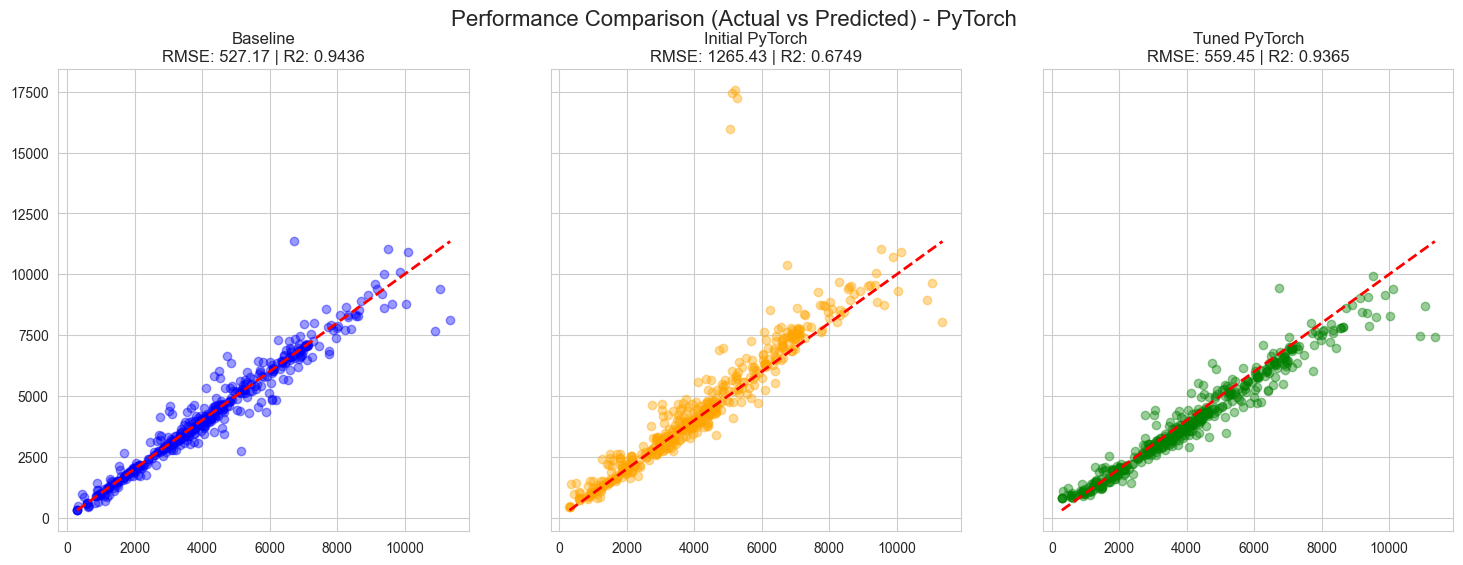

In [19]:
# Calculate R2 for initial model (was missing in previous snippet)
r2_init = r2_score(y_test_raw, y_pred_init)

# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init:.2f}, R2={r2_init:.4f}")
print(f"Tuned Model:    RMSE={rmse_final:.2f}, R2={r2_final:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

y_test_flat = y_test_raw.flatten()
y_pred_final_flat = y_pred_final.flatten()

# Axis Limits
min_val = min(y_test_flat.min(), y_pred_final_flat.min())
max_val = max(y_test_flat.max(), y_pred_final_flat.max())

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.4f}')

# 2. Initial Model Plot
axes[1].scatter(y_test_raw, y_pred_init, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial PyTorch\nRMSE: {rmse_init:.2f} | R2: {r2_init:.4f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test_raw, y_pred_final, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned PyTorch\nRMSE: {rmse_final:.2f} | R2: {r2_final:.4f}')

plt.suptitle('Performance Comparison (Actual vs Predicted) - PyTorch', fontsize=16)
plt.show()

Calculating Permutation Importance (Slow)...


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_11410/2350412142.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




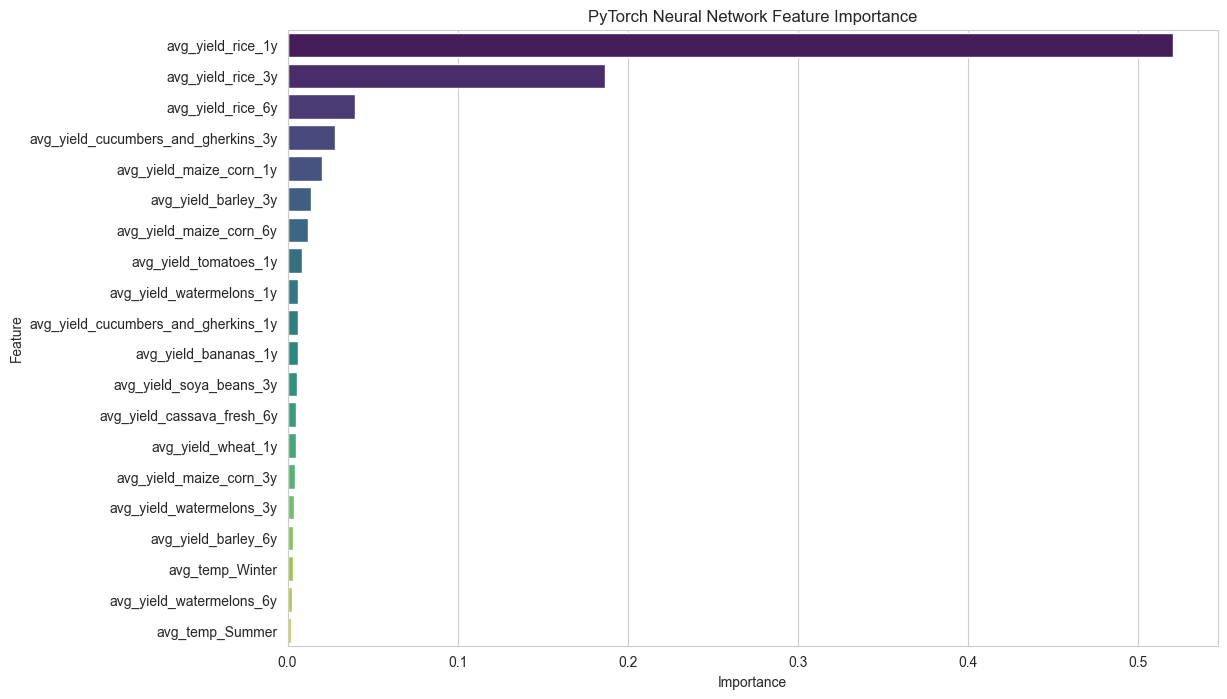

In [20]:
# --- FEATURE IMPORTANCE (Permutation) ---
# Neural Networks need model-agnostic methods like Permutation Importance

def predict_wrapper(model, X):
    # Convert Numpy array back to Tensor for PyTorch model inference
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32).to(device)
        preds = model(inputs)
    return preds.cpu().numpy().flatten()

print("Calculating Permutation Importance (Slow)...")
# Simpler approach since sklearn.permutation_importance expects a fitted estimator:
class PyTorchWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return predict_wrapper(self.model, X)
    def fit(self, X, y): pass # Dummy fit for sklearn compatibility
        
wrapped_model = PyTorchWrapper(final_model)

result = permutation_importance(
    wrapped_model,
    X_test_final_np,
    y_test_raw.flatten(),
    n_repeats=5,
    random_state=42,
    scoring='r2'
)

fi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('PyTorch Neural Network Feature Importance')
plt.show()